# Handwriting generation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import torch.optim as optim
import tqdm
import os
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F

A MOVE to stop Mr . Gaitskell
from nomnating any more Labour
life Peers is to be made at a
meeting of Labour M Ps tomorrow
Mr . Michael Foot has put down a
resolution on the subject


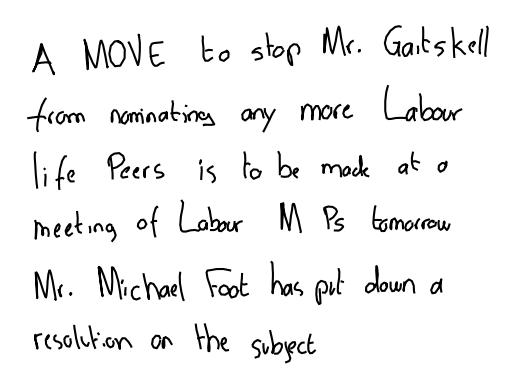

In [2]:
def parse_xml_and_plot(root_filename):
    # Look in the ascii folder for the transcript
    txt_file = f"data/processed/ascii/{root_filename}.txt"
    with open(txt_file, 'r') as f:
      transcript = []
      found_csr = False
      for line in f.readlines():
        line = line.strip()
        if found_csr and line:
          transcript.append(line)

        if line.strip() == 'CSR:':
          found_csr = True

    print('\n'.join(transcript))

    # Parse XML file
    strokess = []
    for i in range(len(transcript)):
      filename = f"data/processed/lineStrokes/{root_filename}-{i+1:02}.xml"
      tree = ET.parse(filename)
      root = tree.getroot()

      # Iterate through each stroke in the StrokeSet
      strokes = []
      for stroke in root.find('StrokeSet'):
        coords = []

        # Extract points from the stroke
        for point in stroke:
          coords.append(
              (int(point.get('x')),
               int(point.get('y')),
               float(point.get('time')))
          )
        strokes.append(np.array(coords))
      strokess.append(strokes)

    # Prepare the Matplotlib figure
    plt.figure()
    for strokes in strokess:
      for i, stroke in enumerate(strokes):
        # Plot the stroke points
        plt.plot(stroke[::2, 0], stroke[::2, 1], 'k')

    plt.axis('equal')
    plt.axis(False)
    plt.box(False)
    plt.gca().invert_yaxis()
    plt.show()
    return strokess

# Example usage
strokess = parse_xml_and_plot('/a01/a01-000/a01-000u')

In [3]:
input_length = 64
output_length = 512

def pad_to(x, pad_length):
  if x.shape[0] > pad_length:
    return x[:pad_length]
  elif x.shape[0] == pad_length:
    return x
  else:
    if x.ndim == 1:
      return np.pad(x, ((0, pad_length - x.shape[0])))
    else:
      return np.pad(x, ((0, pad_length - x.shape[0]), (0, 0)))

class HandwritingDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory with all the data (containing 'ascii' and 'lineStrokes' folders).
        """
        self.root_dir = Path(root_dir)
        self.samples = []

        # Iterate through the directory to get writer names and transcript names
        self.writers = {}
        for writer_dir in (self.root_dir / "lineStrokes").glob('*/'):
            for transcript_dir in writer_dir.glob('*'):
                for file in transcript_dir.glob('*.xml'):
                    # Extract root filename without extension for further use
                    root_filename = file.stem
                    writer = root_filename[:3]
                    if writer == 'z01':
                      continue
                    if root_filename.startswith('a08-551'):
                      continue
                    sample = root_filename[:7]
                    subsample = '-'.join(root_filename.split('-')[:2])
                    line_num = int(root_filename.split('-')[2]) - 1
                    self.samples.append(
                        (writer, sample, subsample, root_filename, line_num)
                    )
                    if writer not in self.writers:
                      self.writers[writer] = len(self.writers)

        self.txt_loaded = {}
        self.buffered = {}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if idx in self.buffered:
          return self.buffered[idx]

        writer, sample, subsample, root_filename, line_num = self.samples[idx]

        # Read transcript
        txt_file = self.root_dir / "ascii" / writer / sample / f"{subsample}.txt"
        cached = False
        if str(txt_file) in self.txt_loaded:
          cached = True
          transcript = self.txt_loaded[str(txt_file)]
        else:
          with open(txt_file, 'r') as f:
              transcript = []
              found_csr = False
              for line in f.readlines():
                  line = line.strip()
                  if found_csr and line:
                      transcript.append(line)
                  if line.strip() == 'CSR:':
                      found_csr = True
          self.txt_loaded[str(txt_file)] = transcript

        try:
          true_sentence = transcript[line_num]
        except IndexError:
          print('---')
          print(transcript)
          print('---')
          print(line_num)
          print(f"could not find {root_filename}")
          print(cached)


        # Parse XML file and create strokes
        filename = self.root_dir / f"lineStrokes" / writer / sample / f"{root_filename}.xml"
        tree = ET.parse(filename)
        root = tree.getroot()

        strokes = []
        for i, stroke in enumerate(root.find('StrokeSet')):
            coords = []

            # Extract points from the stroke
            for j, point in enumerate(stroke):
              if j % 2 == 0 or i == len(stroke) - 1:
                coords.append(
                    (int(point.get('x')),
                     int(point.get('y')),
                     0)  # Regular stroke
                )

            # Add a control character for jump between strokes
            if len(coords) > 0:
                coords[-1] = (coords[-1][0], coords[-1][1], 1)  # Replace last 0 with 1
                strokes += coords

        # Add a control character for the end of a line
        strokes[-1] = (strokes[-1][0], strokes[-1][1], 2)

        strokes = np.array(strokes, dtype=np.float32)
        strokes[1:, :2] = np.diff(strokes[:, :2], axis=0)
        strokes[0, :] = 0
        mean_character = 0
        std_character = [50.0, 50.0, 1.0]

        # std_character = np.array([1000, 1000, 1]).reshape((-1, 3))
        a = pad_to(np.array([ord(x) for x in true_sentence]), input_length)
        b = pad_to((strokes - mean_character) / std_character, output_length)
        b = b.astype(np.float32)

        if strokes.shape[0] < output_length:
          b[strokes.shape[0]:, 0] = -1

        self.buffered[idx] = (self.writers[writer], a, b)
        return self.buffered[idx]

# Example usage
dataset = HandwritingDataset('data/processed')
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
for writer, x, y in dataset:
  break

In [24]:
class StrokeTransformer(nn.Module):
    def __init__(
        self,
        n_writers,
        n_tokens,
        d_model,
        nhead,
        num_decoder_layers,
        dim_feedforward,
        max_seq_length,
        num_mixture,
    ):
        super().__init__()
        self.d_model = d_model
        self.writer_embedding = nn.Embedding(n_writers, d_model)
        self.token_embedding = nn.Embedding(n_tokens, d_model)
        self.positional_encoding_input = nn.Parameter(torch.zeros(max_seq_length, d_model))
        self.positional_encoding_output = nn.Parameter(torch.zeros(max_seq_length, d_model))
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model, nhead, dim_feedforward, batch_first=True
            ),
            num_decoder_layers,
        )
        self.num_mixture = num_mixture
        self.stroke_gaussian_params = nn.Linear(
            d_model, self.num_mixture * 5
        )  # Assuming groups of 5 parameters: cx, cy, width, height, mixture
        self.stroke_presence = nn.Linear(d_model, 3)  # 3-way classifier

        self.past_stroke_embedder = nn.Sequential(
            nn.Linear(3, d_model), nn.ReLU(), nn.Linear(d_model, d_model)
        )

        self.decoding_mask = nn.Transformer.generate_square_subsequent_mask(
            sz=max_seq_length
        )

    def forward(self, writer_tags, text_tokens, past_strokes):
        writer_embeddings = self.writer_embedding(writer_tags)
        token_embeddings = (
            self.token_embedding(text_tokens)
            + self.positional_encoding_input.unsqueeze(0)[:, : text_tokens.shape[1], :]
        )
        seq_embeddings = torch.concat(
            (writer_embeddings.unsqueeze(1), token_embeddings), axis=1
        )

        past_strokes_embedded = self.past_stroke_embedder(past_strokes)
        past_strokes_embedded = (
            past_strokes_embedded
            + self.positional_encoding_output.unsqueeze(0)[:, : past_strokes.shape[1], :]
        )

        memory = self.transformer_decoder(
            past_strokes_embedded,
            seq_embeddings,
            tgt_is_causal=True,
            tgt_mask=self.decoding_mask,
        )
        gaussian_params = self.stroke_gaussian_params(memory)
        shp = gaussian_params.shape
        gaussian_params = gaussian_params.reshape((shp[0], shp[1], self.num_mixture, 5))
        presence_logits = self.stroke_presence(memory)

        return gaussian_params, presence_logits

text_tokens = torch.tensor([ord(x) for x in "Hello world"])
hello_world = torch.zeros(1, 256).to(device="cuda", dtype=torch.long)
hello_world[:, : len(text_tokens)] = text_tokens

n_writers = len(dataset.writers)
n_tokens = 256  # ASCII
d_model = 256
nhead = 8
num_decoder_layers = 6
dim_feedforward = 256
max_seq_length = output_length  # We slightly downsampled to make things a bit easier
num_mixture = 3

model = StrokeTransformer(
    n_writers,
    n_tokens,
    d_model,
    nhead,
    num_decoder_layers,
    dim_feedforward,
    max_seq_length,
    num_mixture,
)
model = model.to("cuda")
sum(p.numel() for p in model.parameters())

4393234

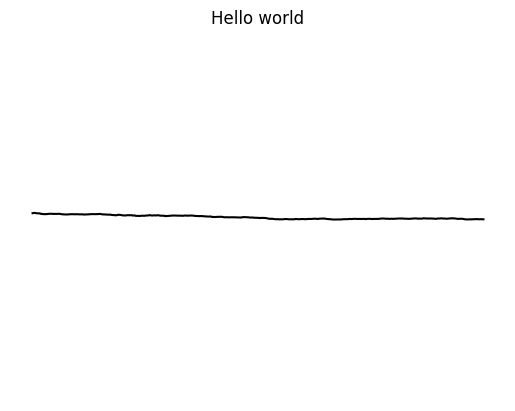

In [5]:
def draw_sample(strokes, gaps=False):
    def add_gaps(data):
        cases = []
        for row in data:
            cases.append(row)
            if row[-1] > 0:
                cases.append((np.nan, np.nan, np.nan))
        return np.array(cases)

    stroke_path = strokes.cpu().detach().numpy()
    stroke_path[..., :2] = np.cumsum(stroke_path[..., :2], axis=1)

    last_line_height = 0
    for i in range(stroke_path.shape[0]):
        path = stroke_path[i]
        line_max = path[:, 1].max()
        if gaps:
            path = add_gaps(path)

        plt.plot(path[:, 0], path[:, 1] + last_line_height, "k-")

        last_line_height += line_max + 1

    plt.axis("equal")
    plt.axis(False)
    plt.box(False)
    plt.gca().invert_yaxis()
    plt.title("Hello world")
    plt.show()


# Train MOG model

In [7]:
def conditional_decode_mog(
        model, 
        writer_tags, 
        text_tokens,
        T=1.0):
    
    # Decode until done.
    bias = torch.tensor([0, 0, 0], device='cuda')
    model.eval()
    past_strokes = torch.zeros(writer_tags.shape[0], 256, 3, device="cuda")
    for i in range(255):
        gaussian_params, presence_logits = model.forward(
            writer_tags, text_tokens, past_strokes
        )

        # gaussian_params: (batch_size, seq_len, num_mixture, 5)
        next_gaussian_params = gaussian_params[:, i, :, :]
        next_presence_logits = presence_logits[:, i, :]

        if T == 0:
            # Reassemble the highest likelihood sample in a greedy way
            chosen_mixture = torch.argmax(next_gaussian_params[..., -1], dim=1)
            
            # Next, we want to select the parameters of the chosen mixture
            chosen_gaussian_params = next_gaussian_params[
                torch.arange(next_gaussian_params.shape[0]), 
                chosen_mixture, 
                :]

            new_past_strokes = torch.concat(
                [
                    chosen_gaussian_params[:, :2],
                    torch.argmax(next_presence_logits, dim=1).unsqueeze(1),
                ],
                dim=1,
            )
        else:
            # Sample from the mixture
            chosen_mixture = torch.distributions.multinomial.Multinomial(
                total_count=1,
                logits=1 / T * next_gaussian_params[..., -1]
            ).sample().argmax(dim=1)

            # Next, we want to select the parameters of the chosen mixture
            chosen_gaussian_params = next_gaussian_params[
                torch.arange(next_gaussian_params.shape[0]), 
                chosen_mixture, 
                :]
            
            next_presence = torch.distributions.multinomial.Multinomial(
                total_count=1,
                logits=1 / T * next_presence_logits + bias.unsqueeze(0)
            ).sample().argmax(dim=1)

            # Sample
            center_stroke = chosen_gaussian_params[:, :2] + T * torch.randn_like(chosen_gaussian_params[:, :2]) * torch.exp(chosen_gaussian_params[:, 2:4])
            new_past_strokes = torch.concat(
                [
                    center_stroke,
                    next_presence.unsqueeze(1),
                ],
                dim=1,
            )
        
        past_strokes[:, i+1, :] = new_past_strokes

    # Now integrate over time to get the final stroke
    return past_strokes

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("logs")

# Hyperparameters
learning_rate = 1e-2
epochs = 500

# Loss Functions
presence_loss_fn = nn.CrossEntropyLoss(
    reduction="none"
)  # Cross-entropy loss for presence classification

# Adds up to about the same capacity as the LSTM model from Graves (2013).
num_mixture = 10
model = StrokeTransformer(
    n_writers,
    n_tokens,
    d_model,
    nhead,
    num_decoder_layers,
    dim_feedforward,
    max_seq_length,
    num_mixture,
)
model = model.to("cuda")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=2e-3,
    steps_per_epoch=len(dataloader),
    epochs=epochs,
    pct_start=0.1,
)

prev_loss = float("inf")
loss_threshold = 0.1  # Define your threshold
lr_decrease_factor = 0.1  # Define how much to decrease the learning rate
locked_until = - 1
lock_epochs = 5

# Training Loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    i = 0
    torch.save(model.state_dict(), f"checkpoints/model_checkpoint_{epoch}.pth")

    with tqdm.tqdm(
        total=len(dataloader), desc=f"Epoch {epoch + 1}/{epochs}", unit=" samples"
    ) as pbar:
        for writer_tags, text_tokens, strokes in tqdm.tqdm(dataloader):
            # Forward pass
            optimizer.zero_grad()
            writer_tags = writer_tags.to("cuda")
            text_tokens = text_tokens.to("cuda")
            strokes = strokes.to("cuda")

            # Randomly mask out some of the strokes to force it to pay attention to the conditioning text.
            mask = torch.rand(strokes.shape[0], strokes.shape[1], device="cuda") > 0.25
            strokes_masked = strokes * mask.unsqueeze(2)

            gaussian_params, presence_logits = model(
                writer_tags, text_tokens, strokes_masked
            )

            # Teacher forcing
            strokes = strokes[:, 1:]
            gaussian_params = gaussian_params[:, :-1]
            presence_logits = presence_logits[:, :-1]

            pred_means = gaussian_params[
                ..., :, :2
            ]  # Assuming the first two columns are x, y means
            pred_stds = torch.exp(
                gaussian_params[..., :, 2:4]
            )  # Assuming the 3-4 columns are std_dev_x, std_dev_y
            pred_weights = gaussian_params[
                ..., :, 4
            ]  # Assuming the last is the mixture weight

            pred_weights = F.softmax(pred_weights, dim=-1)

            # Calculate the likelihoods here rather than the more conventional log likelihood
            E = torch.exp(
                (
                    -1
                    / 2
                    * (strokes[..., :2].unsqueeze(2) - pred_means) ** 2
                    / pred_stds**2
                ).sum(3)
            )
            E = E / (pred_stds[..., 0] * pred_stds[..., 1])
            L = (pred_weights * 1 / 2 / torch.pi * E).sum(dim=2)

            # Transform that into a negative log-likelihood
            gaussian_loss = -torch.log(L + 1e-6)

            presence_labels = strokes[:, :, -1]
            assert torch.unique(presence_labels).shape[0] > 1
            mask = strokes[..., 0] != -1

            # Presence Loss
            presence_loss = presence_loss_fn(
                presence_logits.permute(0, 2, 1), presence_labels.to(torch.long)
            )

            # Total loss
            loss = (mask * (gaussian_loss + presence_loss)).sum() / mask.sum()

            # Backward pass and optimize
            loss.backward()

            torch.nn.utils.clip_grad_value_(model.parameters(), 10)

            optimizer.step()
            if epoch > locked_until:
                scheduler.step()

            total_loss += loss.item()
            # print(loss.item(), pred_stds.mean().item())
            pbar.set_postfix(
                **{"loss (batch)": loss.item(), "std": pred_stds.mean().item()}
            )
            # print(loss.item())
            pbar.update(strokes.shape[0])

            writer.add_scalar("Train/Loss", loss, epoch)

    with torch.no_grad():
        decoded = conditional_decode_mog(
            model,
            0 * torch.ones(6, device="cuda", dtype=torch.long),
            hello_world.tile((6, 1)),
            T=0.5,
        )
    draw_sample(decoded, gaps=True)

    # Print average loss per epoch
    avg_loss = (total_loss / len(dataloader))
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss}")

    if avg_loss > prev_loss + loss_threshold:
        for g in optimizer.param_groups:
            g["lr"] = g["lr"] * lr_decrease_factor
        
        locked_until = epoch + lock_epochs

        # Load checkpoint from 2 epochs ago
        model.load_state_dict(
            torch.load(f"checkpoints/model_checkpoint_{epoch-2}.pth")
        )
        print("Loss increased, resetting to old checkpoint, temporarily decreasing and locking learning rate")

    prev_loss = avg_loss

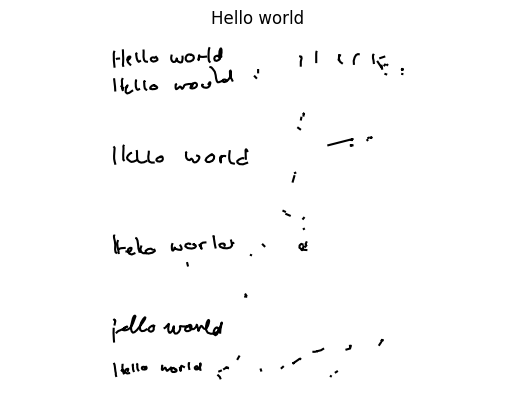

In [20]:
with torch.no_grad():
    decoded = conditional_decode_mog(model, 
                                 0 * torch.ones(6, device='cuda', dtype=torch.long), 
                                 hello_world.tile((6, 1)),
                                 T=1)

draw_sample(decoded, gaps=True)